<a href="https://colab.research.google.com/github/amramer/Semantic-Segmentation-for-Autonomous-Vehicles/blob/main/Segmentation_Model_Autonomous_Vehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semantic Segmentation Model For Autonomous Vehicle**


## 🔧 Setup: Install & Import Libraries

In [ ]:
# Installing Dependencies
!wget https://raw.githubusercontent.com/amramer/Semantic-Segmentation-Model-for-Autonomous-Vehicles-An-End-to-End-ML-Workflow/refs/heads/main/requirements.txt
!wget https://raw.githubusercontent.com/amramer/Semantic-Segmentation-Model-for-Autonomous-Vehicles-An-End-to-End-ML-Workflow/refs/heads/main/params.py
!wget https://raw.githubusercontent.com/amramer/Semantic-Segmentation-Model-for-Autonomous-Vehicles-An-End-to-End-ML-Workflow/refs/heads/main/utils.py
!pip install -r requirements.txt
!pip install gdown


In [4]:
# Importing Libraries
import wandb
import params
import pandas as pd
import torchvision.models as tvmodels
import gdown
import zipfile
import os, warnings
warnings.filterwarnings('ignore')
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from fastai.vision.augment import *
from sklearn.model_selection import *
from utils import *
from pathlib import Path

## 🚀 Initialize W&B Run for Experiment Tracking

In [ ]:
# Starting a new W&B run with project name and entity
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY)

## 📂 Download and Extract Dataset

In [ ]:
# Download the dataset from Google Drive
file_id = '1IUCBN5kMrDUd8SnXJvyOkSPRkuQqou62'
gdown.download(f'https://drive.google.com/uc?id={file_id}', 'bdd_simple_1k.zip', quiet=False)

# Unzip the downloaded dataset
with zipfile.ZipFile('bdd_simple_1k.zip', 'r') as zip_ref:
    zip_ref.extractall('bdd_dataset')

# Define the path to the dataset
path = Path('bdd_dataset/BDD_SIMPLE_1k')
# List the contents of the dataset directory
for file in path.iterdir():
    print(file)  # Print each file in the dataset directory


## 🛠️ Data Preprocessing & W&B Table Creation

In [ ]:
# Defining functions to preprocess data and uploading it as Table on W&B
def label_func(fname):
    return (fname.parent.parent/"labels")/f"{fname.stem}_mask.png"

def get_classes_per_image(mask_data, class_labels):
    unique = list(np.unique(mask_data))
    result_dict = {}
    for _class in class_labels.keys():
        result_dict[class_labels[_class]] = int(_class in unique)
    return result_dict

def _create_table(image_files, class_labels):
    "Create a table with the dataset"
    labels = [str(class_labels[_lab]) for _lab in list(class_labels)]
    table = wandb.Table(columns=["File_Name","P1","P2" ,"Images", "Dataset"] + labels)

    for i, image_file in progress_bar(enumerate(image_files), total=len(image_files)):
        # print(image_file)
        image = Image.open(image_file)
        mask_data = np.array(Image.open(label_func(image_file)))
        class_in_image = get_classes_per_image(mask_data, class_labels)
        table.add_data(
            str(image_file.name),
            image_file.stem.split('-')[0],
            image_file.stem.split('-')[1],
            wandb.Image(
                    str(image_file),
                    masks={
                        "predictions": {
                            "mask_data": mask_data,
                            "class_labels": class_labels,
                        }
                    }
            ),
            "BDD100k", # dataset name
            *[class_in_image[_lab] for _lab in labels]
        )

    return table


## 📦 Create and Log W&B Artifact

In [ ]:
# Creating artificat
raw_data_at = wandb.Artifact(params.RAW_DATA_AT, type="raw_data")

# Adding images and labels of dataset to artificat in W&B
raw_data_at.add_file(path/'LICENSE.txt', name='LICENSE.txt')
raw_data_at.add_dir(path/'images', name='images')
raw_data_at.add_dir(path/'labels', name='labels')

# Getting the names of the images and labels
image_files = get_image_files(path/"images", recurse=False)
labels_files = get_image_files(path/"labels", recurse=False)

# Creating W&B Table
table = _create_table(image_files, params.BDD_CLASSES)

# Adding table to our W&B artificat and and log to W&B
raw_data_at.add(table, "Samples_data")
run.log_artifact(raw_data_at)
run.log({"Samples_data":table})

## ⚙️ Data Preparation

In [ ]:
# Retrieving the latest version of the dataset artifact stored in W&B,
# downloading it locally.
raw_data_at = run.use_artifact(f'{params.RAW_DATA_AT}:latest')
path = Path(raw_data_at.download())
path.ls()

In [ ]:
# Acessing the Data Samples table
# This table includes important columns like filenames, class labels (e.g., bicycle), and other attributes (e.g., P1, P2)
Samples_data_table = raw_data_at.get("Samples_data")

# Extracting File Names and grouping by Video Identifier P1
# Grouping images that likely come from the same video
fnames = Samples_data_table.get_column("File_Name")
groups = [s.split('-')[0] for s in fnames]

# Use the 'bicycle' column (our target class) from the Data Samples table for stratified splitting
y = Samples_data_table.get_column("bicycle")

We will now split the data into training (80%), validation (10%), and test (10%) sets, while addressing two key considerations:



*   **Avoiding Data Leakage:** To ensure the model can generalize to new scenes, we group the data by video identifiers. This prevents similar frames from the same video from being split across training, validation, or test sets.To avoid overfiting and ensures the model generalizes to new data.

*  **Handling Class Imbalance:** To address the imbalance in our target class (e.g., the rare 'bicycle' class), we use stratification based on the target labels, ensuring balanced representation in each split.

Using `StratifiedGroupKFold` from `sklearn`, we split the data into 10 folds, with 1 fold assigned to testing, 1 to validation, and the remaining 8 folds for training.


In [ ]:
# Creating a DataFrame to store filenames and correspondig fold
df = pd.DataFrame()

# Adding filenames to the DataFrame
df['File_Name'] = fnames

# Initializing the fold column with -1
df['fold'] = -1

In [ ]:
# Initializing StratifiedGroupKFold with 10 splits,
# stratifying by class and grouping by video identifier (P1)
cv = StratifiedGroupKFold(n_splits=10)

# Splitting the data using the stratified group K-fold split method
for i, (train_idxs, test_idxs) in enumerate(cv.split(fnames, y, groups)):
    # Assigning the fold number to the test indexes in the DataFrame
    df.loc[test_idxs, ['fold']] = i

In [ ]:
# Setting the initial split as 'train' for all data points
df['Split'] = 'train'

# Assigning fold 0 as the test set
df.loc[df.fold == 0, ['Split']] = 'test'

# Assigning fold 1 as the validation set
df.loc[df.fold == 1, ['Split']] = 'valid'

# Removing the fold column
del df['fold']

# Checking the counts of data points in each data split(80% train, 10% vaild, 10% test)
df.Split.value_counts()


,count
Split,
train,800
valid,100
test,100


In [ ]:
# Saving the split data to a CSV file
df.to_csv('data_split.csv', index=False)

In [ ]:
# Creating a new W&B artifact to store the processed split data
processed_data_at = wandb.Artifact(params.PROCESSED_DATA_AT, type="split_data")

# Adding the data split CSV file and the original dataset directory to the artifact
processed_data_at.add_file('data_split.csv')
processed_data_at.add_dir(path)

In [ ]:
# Creating a W&B table for the data splits (File_Name and Split)
data_split_table = wandb.Table(dataframe=df[['File_Name', 'Split']])

# Joining the original samples data table with the data split table on the 'File_Name' column
join_table = wandb.JoinedTable(Samples_data_table, data_split_table, "File_Name")

In [ ]:
# Adding the joined table to the artifact
processed_data_at.add(join_table, "sample_table_data_split")

In [ ]:
# Log the processed data artifact to W&B
run.log_artifact(processed_data_at)
run.log({"Sample_table_Data_split":join_table})

The logged data split table displays each image as a row, with its corresponding segmentation mask, labels, and a split column indicating whether the image belongs to the train, validation, or test set.

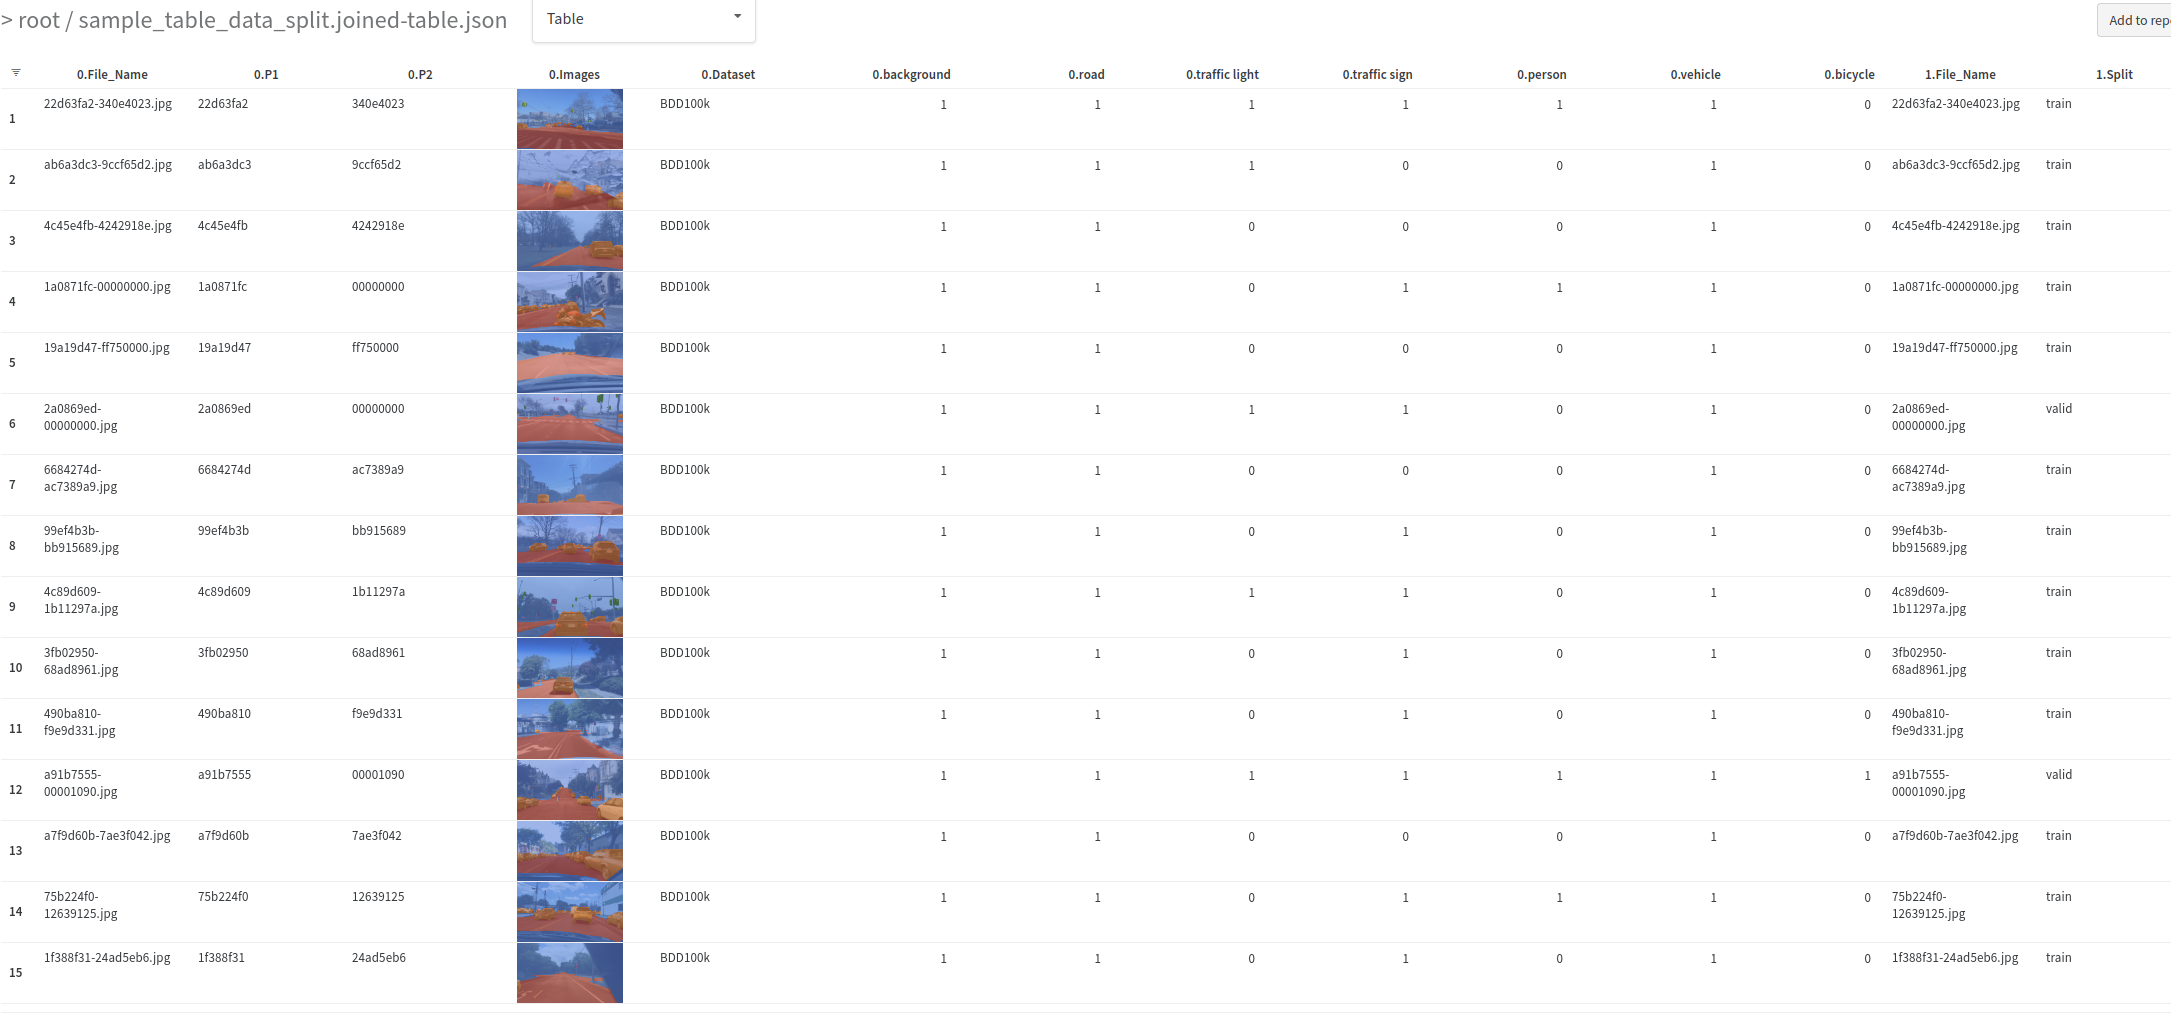

## 🏋️‍♂️ Training the Baseline Model


In [ ]:
# Defining a 'train_config' that we'll pass to W&B run to control training hyperparameters
train_config = SimpleNamespace(
    framework="fastai",
    img_size=(180, 320),
    batch_size=8,
    augment=True, # use data augmentation
    epochs=50,
    lr=2e-3,
    pretrained=True,  # whether to use pretrained encoder
    seed=42,
)

In [ ]:
# Setting the seed for reproducibilty
set_seed(train_config.seed, reproducible=True)

In [ ]:
# Intializing a W&B run for tracking the experiment and passing the training configuration
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type="training", config=train_config)

In [ ]:
# Loading the latest processed dataset artifact from W&B and download it to the local directory
processed_data_at = run.use_artifact(f'{params.PROCESSED_DATA_AT}:latest')
processed_dataset_dir = Path(processed_data_at.download())
processed_dataset_dir.ls()

In [ ]:
# Reading the 'data_split.csv' that contains the dataset split (train/valid/test) info
df = pd.read_csv(processed_dataset_dir / 'data_split.csv')

In [ ]:
# Filtering out the 'test' set, keeping only training and validation data
df = df[df.Split != 'test'].reset_index(drop=True)

# Adding a new column 'is_valid' that marks vaildation images
df['is_valid'] = df.Split == 'valid'

In [ ]:
# Function to get the corresponding label path for each image
def label_func(fname):
    return (fname.parent.parent/"labels")/f"{fname.stem}_mask.png"

# Assigning paths for image and mask files
df["image_fname"] = [processed_dataset_dir/f'images/{f}' for f in df.File_Name.values]
df["label_fname"] = [label_func(f) for f in df.image_fname.values]

In [ ]:
# Function to prepare data for training with augmentation, resizing, and batching
def get_data(df, bs=4, img_size=(180, 320), augment=True):
    block = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=params.BDD_CLASSES)),  # Define input and output types
        get_x=ColReader("image_fname"),  # Load image paths
        get_y=ColReader("label_fname"),  # Load corresponding mask paths
        splitter=ColSplitter(),          # Split into training and validation
        item_tfms=Resize(img_size),      # Resize images and masks to the defined size
        batch_tfms=aug_transforms() if augment else None  # Apply augmentation if enabled
    )
    return block.dataloaders(df, bs=bs)

In [ ]:
# Using the wandb.config to access hyperparameters and other settings
config = wandb.config

# Preparing the DataLoaders with the specified batch size, image size, and augmentation.
dls = get_data(df, bs=config.batch_size, img_size=config.img_size, augment=config.augment)

In [ ]:
# Defining metrics for evaluating the model: MIOU and IOU for individual classes
metrics = [MIOU(), BackgroundIOU(), RoadIOU(), TrafficLightIOU(),
           TrafficSignIOU(), PersonIOU(), VehicleIOU(), BicycleIOU()]

In [ ]:
# Creating a U-Net model with a ResNet18 backbone, using the pre-trained model if specified
learn = unet_learner(dls, arch=resnet18, pretrained=config.pretrained, metrics=metrics)

# Defining callbacks: Save the best model and log details to W&B
callbacks = [
    SaveModelCallback(monitor='miou'),  # Save the model with the best Mean IOU
    WandbCallback(log_preds=False, log_model=True)  # Log the model to W&B
]

U-Net segmentation model(original paper https://arxiv.org/pdf/1505.04597)

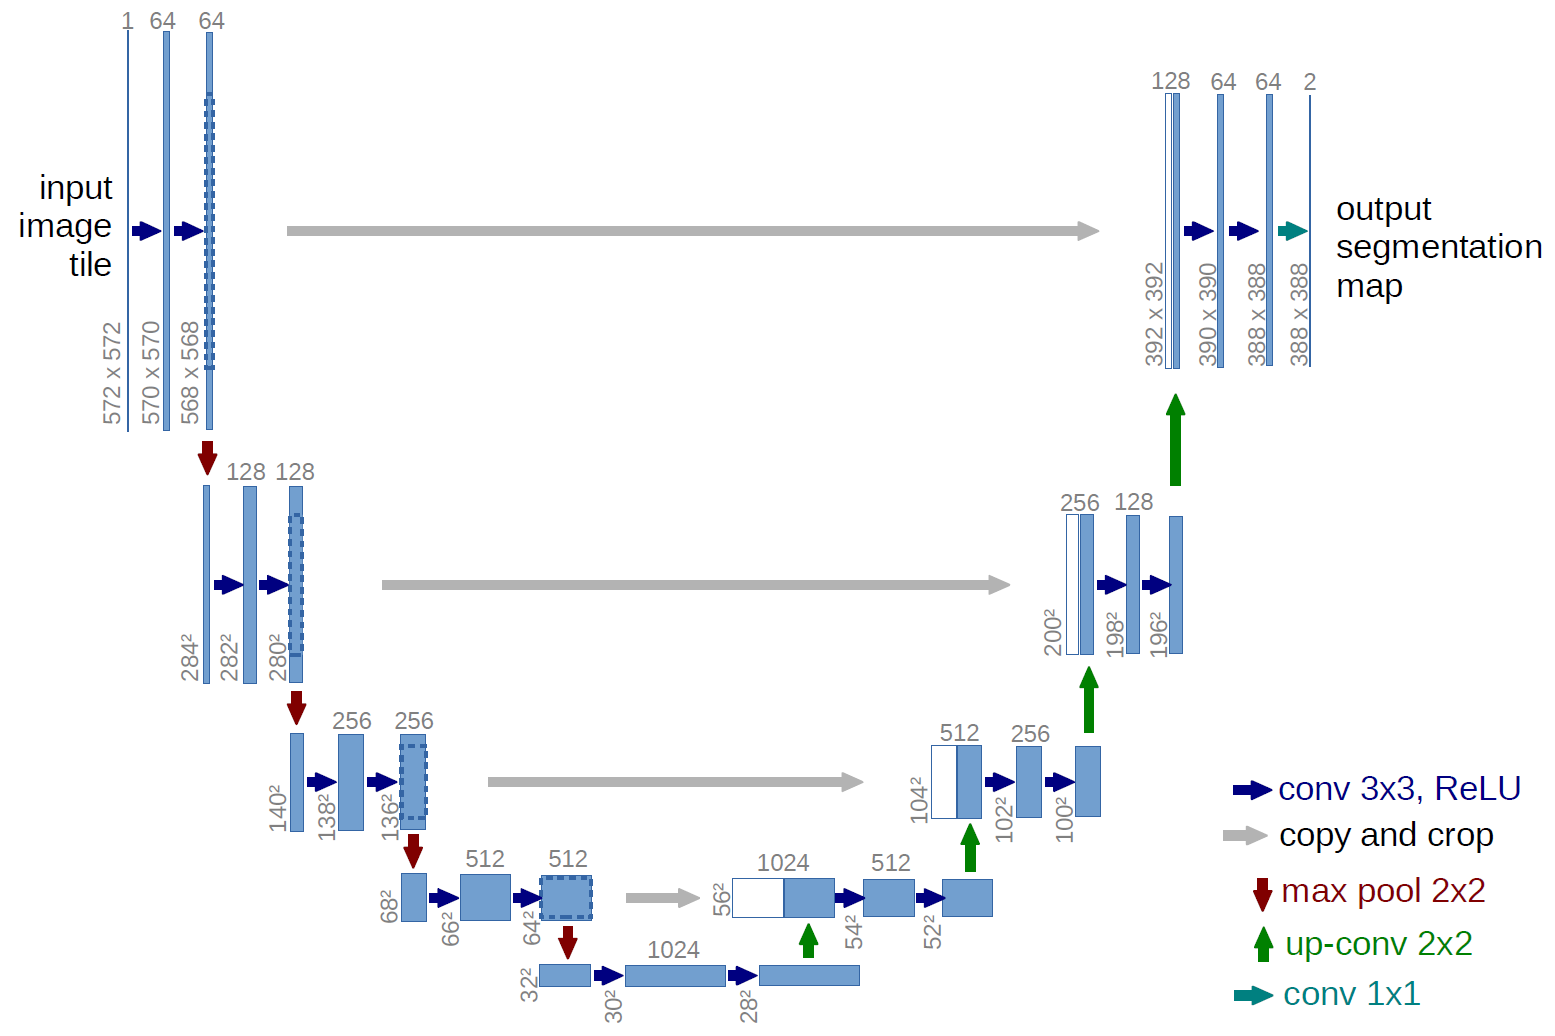

In [ ]:
# Training the model for the specified number of epochs using 1-cycle learning rate
learn.fit_one_cycle(config.epochs, config.lr, cbs=callbacks)

In [ ]:
# Getting predictions from the model after training, for error analysis
samples, outputs, predictions = get_predictions(learn)

# Creating a table with IOU metrics and predictions for visualizing results in W&B
table = create_iou_table(samples, outputs, predictions, params.BDD_CLASSES)
wandb.log({"pred_table": table})  # Log the prediction table to W&B

In [ ]:
# Reloading the best model from the checkpoint and validate it on the validation set
scores = learn.validate()

In [ ]:
# Tracking the final metrics (loss, IOU for each class, etc.) and log them to W&B summary
metric_names = ['final_loss'] + [f'final_{x.name}' for x in metrics]
final_results = {metric_names[i]: scores[i] for i in range(len(scores))}

# Logging each final metric to the W&B summary for tracking
for k, v in final_results.items():
    wandb.summary[k] = v

In [ ]:
# Finish the W&B run after training and logging
wandb.finish()

Below is the logged Intersection over Union (IoU) metric for each class and the corresponding loss from Weights & Biases (W&B):

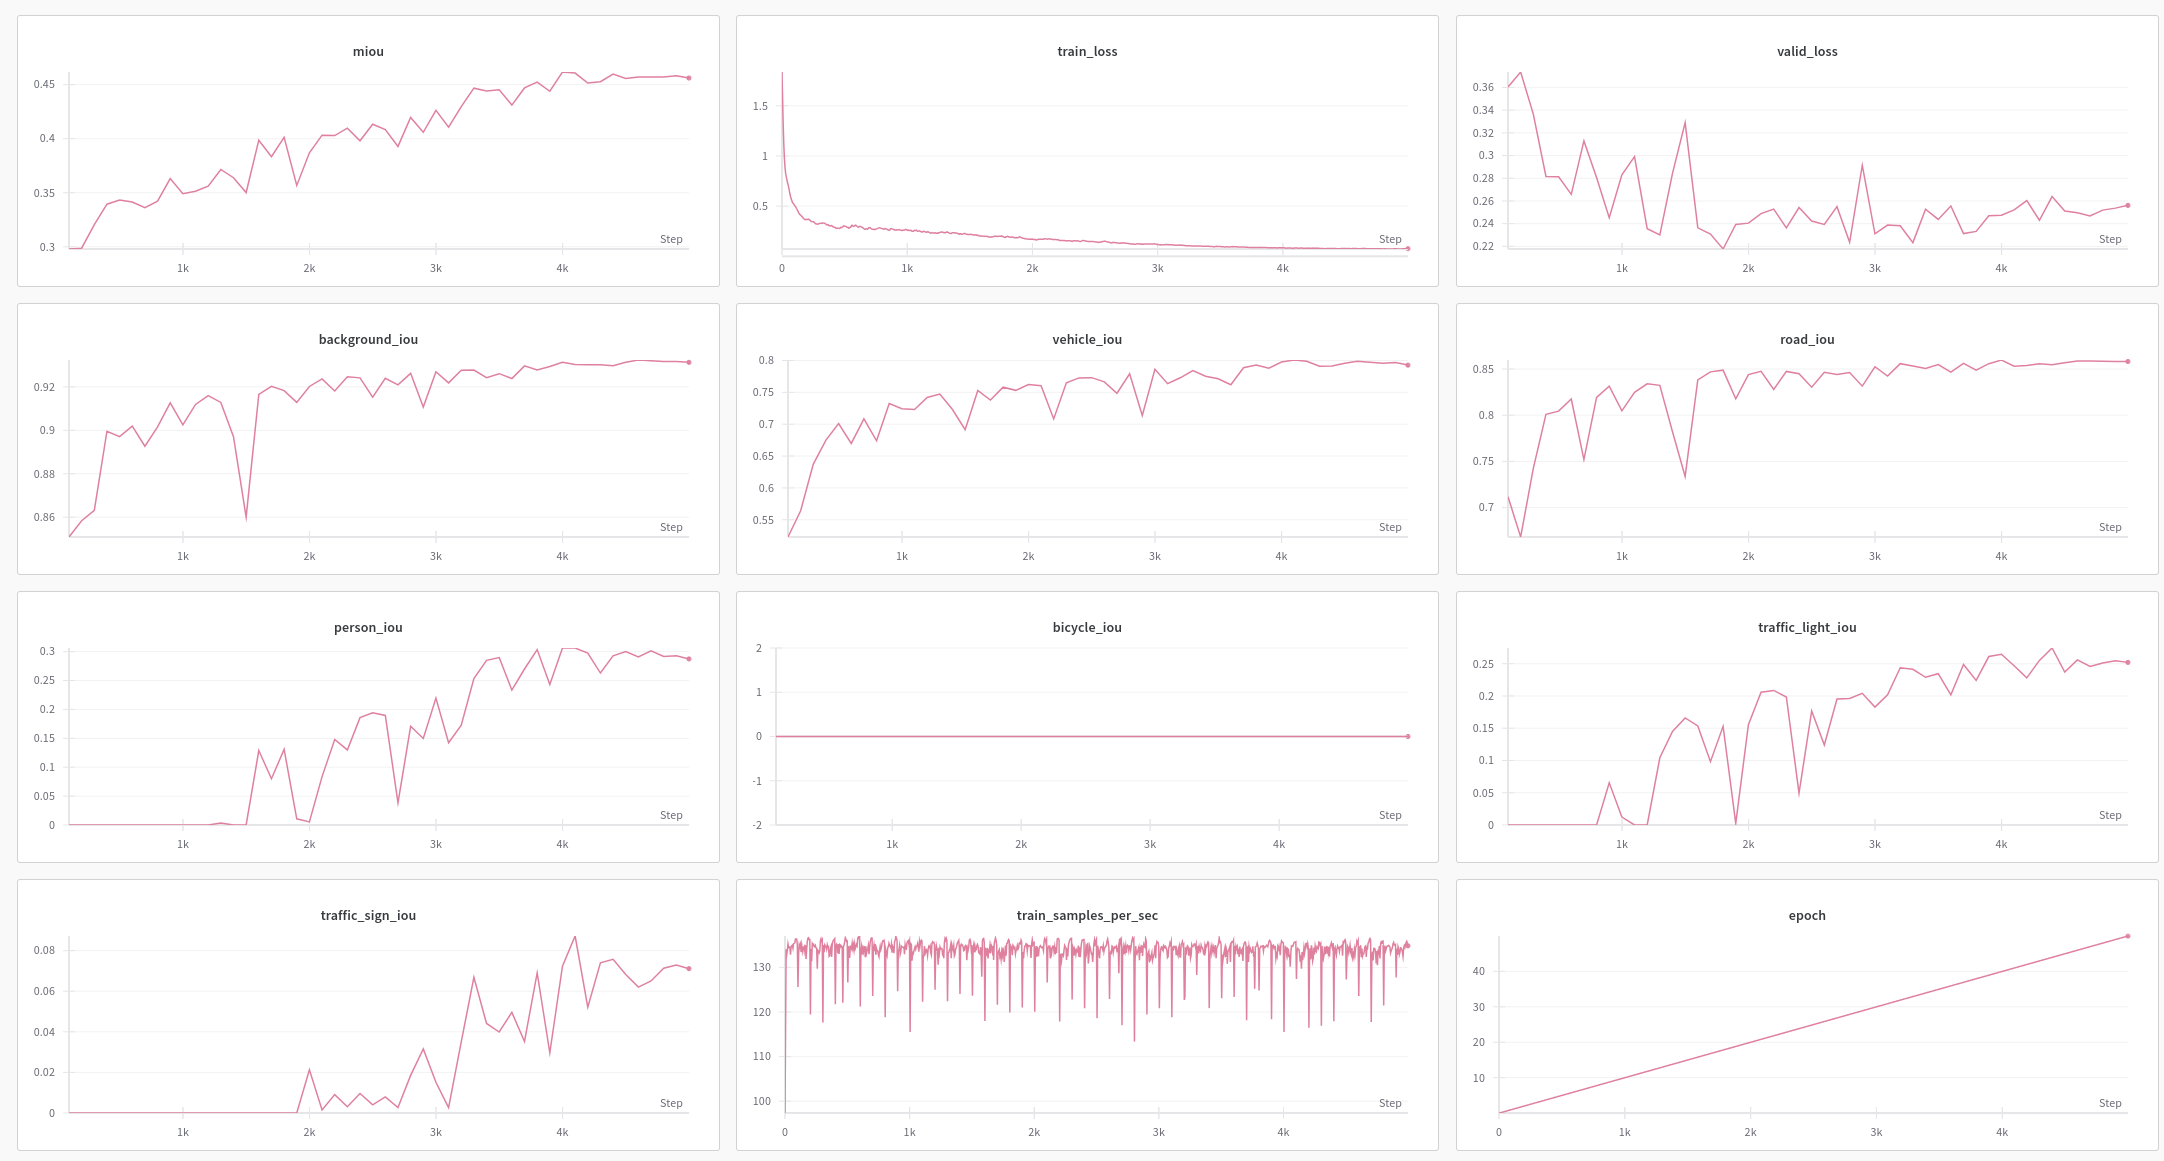

## 📊 Model Evaluation and Analysis

In this final stage, we will assess our model performance and run some analysis.

We will begin by defining a few functions before proceeding with the evaluation.

In [5]:
# Function to download the dataset from W&B Artifact
def download_data():
    """Download the processed dataset from W&B Artifact."""
    processed_data_at = wandb.use_artifact(f'{params.PROCESSED_DATA_AT}:latest')
    processed_dataset_dir = Path(processed_data_at.download())
    return processed_dataset_dir

In [6]:
# Function to retrieve the corresponding label path for each image
def label_func(fname):
    """Get the label (mask) file path for a given image file."""
    return (fname.parent.parent/"labels")/f"{fname.stem}_mask.png"

In [7]:
# Function to load the dataframe with image file names and splits
def get_df(processed_dataset_dir, is_test=False):
    """
    Load the data split CSV and assign corresponding file paths.

    Parameters:
    - processed_dataset_dir: Path to the dataset directory.
    - is_test: Boolean to indicate whether to use test split or train/valid.

    Returns:
    - Updated dataframe with image and label paths.
    """
    df = pd.read_csv(processed_dataset_dir / 'data_split.csv')

    if not is_test:
        # Use train and validation data, exclude test data
        df = df[df.Split != 'test'].reset_index(drop=True)
        df['is_valid'] = df.Split == 'valid'
    else:
        # Use validation and test data, exclude training data
        df = df[df.Split != 'train'].reset_index(drop=True)
        df['is_valid'] = df.Split == 'valid'

    # Assign image and label file paths to dataframe
    df["image_fname"] = [processed_dataset_dir/f'images/{f}' for f in df.File_Name.values]
    df["label_fname"] = [label_func(f) for f in df.image_fname.values]
    return df

In [15]:
# Function to create a DataLoaders object
def get_data(df, bs=4, img_size=180, augment=True):
    """
    Create DataLoaders for training, validation, or testing.

    Parameters:
    - df: Dataframe containing image and label paths.
    - bs: Batch size for loading data.
    - img_size: Image dimensions (height), can be a single integer or list.
    - augment: Boolean to apply data augmentation during training.

    Returns:
    - DataLoaders object.
    """
    # Ensure img_size is an integer
    if isinstance(img_size, list):
        img_size = img_size[0]  # If a list, take the first element

    block = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=params.BDD_CLASSES)),
        get_x=ColReader("image_fname"),
        get_y=ColReader("label_fname"),
        splitter=ColSplitter(),
        item_tfms=Resize((img_size, int(img_size * 16 / 9))),  # Resize maintaining aspect ratio
        batch_tfms=aug_transforms() if augment else None  # Apply augmentation if specified
    )
    return block.dataloaders(df, bs=bs)

In [9]:
# Function to log predictions as a table in W&B
def log_predictions(learn):
    """Log model predictions and metrics to W&B as a table."""
    samples, outputs, predictions = get_predictions(learn)
    table = create_iou_table(samples, outputs, predictions, params.BDD_CLASSES)
    wandb.log({"val_pred_table": table})

In [10]:
# Utility function to count occurrences of each class in predictions
def count_by_class(arr, cidxs):
    """Count the occurrences of each class in the predictions."""
    return [(arr == n).sum(axis=(1, 2)).numpy() for n in cidxs]

In [11]:
# Function to log a histogram of class counts (target vs predictions)
def log_hist(c):
    """
    Plot and log histograms of class distribution in target vs predictions.

    Parameters:
    - c: Class index to be visualized.
    """
    _, bins, _ = plt.hist(target_counts[c], bins=10, alpha=0.5, density=True, label='target')
    _ = plt.hist(pred_counts[c], bins=bins, alpha=0.5, density=True, label='pred')
    plt.legend(loc='upper right')
    plt.title(params.BDD_CLASSES[c])

    img_path = f'hist_val_{params.BDD_CLASSES[c]}'
    plt.savefig(img_path)
    plt.clf()

    # Log histogram image to W&B
    im = plt.imread(f'{img_path}.png')
    wandb.log({img_path: wandb.Image(f'{img_path}.png', caption=img_path)})

In [ ]:
# Intializing a W&B run for evaluation
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type="evaluation", tags=['staging'])

# Download the model artifact from W&B registry and list its contents
artifact = run.use_artifact('amribrahim-amer-2024-org/wandb-registry-model/Autonomous Driving Semantic Segmentation:v0', type='model')
artifact_dir = Path(artifact.download())
artifact_dir.ls()

In [ ]:
# Get the full model path from the downloaded artifact
# Grab the first file in the directory (likely the model file)
_model_pth = artifact_dir.ls()[0]
# Form the absolute path without the file extension
model_path = _model_pth.parent.absolute()/_model_pth.stem

# Get the configuration of the model producer run and update the current W&B config
# Retrieve the original run that logged this artifact (model)
producer_run = artifact.logged_by()
# Update the current W&B config to match the producer run's config
wandb.config.update(producer_run.config)
# Store the updated configuration locally
config = wandb.config
# showing metrics summmary of the model producer run
producer_run.summary

**Summary:** This block of code initializes a W&B run for model evaluation, retrieves the model artifact, gets the full path to the model file, and ensures that the evaluation run is using the same configuration as the model training run. This is essential for consistency and accurate comparison between training and evaluation results.

In [ ]:
# Download the processed dataset from the W&B artifact and return the directory path
processed_dataset_dir = download_data()

# Retrieve the test and validation data from the dataset, excluding training data
test_valid_df = get_df(processed_dataset_dir, is_test=True)

# Create DataLoaders for the test and validation datasets
test_valid_dls = get_data(test_valid_df, bs=config.batch_size, img_size=config.img_size, augment=config.augment)

In [19]:
# Safely retrieve 'mixed_precision' from the config, defaulting to False if not found
mixed_precision_enabled = getattr(config, 'mixed_precision', False)

# Define metrics to evaluate the model on different classes
metrics = [MIOU(), BackgroundIOU(), RoadIOU(), TrafficLightIOU(),
           TrafficSignIOU(), PersonIOU(), VehicleIOU(), BicycleIOU()]

# Define callbacks for mixed precision if configured
cbs = [MixedPrecision()] if mixed_precision_enabled else []

In [ ]:
# Access the model architecture from the Learner configuration in the config object
arch = config.Learner['arch'] if 'arch' in config.Learner else 'resnet18'

# Initialize a U-Net learner with the given architecture and metrics
learn = unet_learner(
    test_valid_dls,
    arch=getattr(tvmodels, arch.split('.')[-1]),
    pretrained=config.pretrained,
    metrics=metrics
)

# Load the pre-trained model weights from the specified path
learn.load(model_path)

# Validate the model on the validation set (index 1 corresponds to validation data)
val_metrics = learn.validate(ds_idx=1)

# Validate the model on the test set (index 0 corresponds to test data)
test_metrics = learn.validate(ds_idx=0)

In [ ]:
# Create a list of metric names for validation metrics
val_metric_names = ['val_loss'] + [f'val_{x.name}' for x in learn.metrics]  # Prefix 'val_' to each metric for validation

# Create a dictionary mapping validation metric names to their corresponding values from the validation set
val_results = {val_metric_names[i] : val_metrics[i] for i in range(len(val_metric_names))}

# Log each validation result to W&B summary for tracking
for k, v in val_results.items():
    wandb.summary[k] = v

# Create a list of metric names for test metrics
test_metric_names = ['test_loss'] + [f'test_{x.name}' for x in learn.metrics]  # Prefix 'test_' to each metric for test

# Create a dictionary mapping test metric names to their corresponding values from the test set
test_results = {test_metric_names[i] : test_metrics[i] for i in range(len(test_metric_names))}

# Log each test result to W&B summary for tracking
for k, v in test_results.items():
    wandb.summary[k] = v

# Log a table containing model predictions and corresponding metrics
log_predictions(learn)

In [26]:
# Get predicted probabilities and target values for the validation dataset
# ds_idx=1 refers to the validation set
val_probs, val_targs = learn.get_preds(ds_idx=1)

# Get the predicted class labels by taking the index of the highest probability for each pixel
# Returns the predicted class index for each pixel
val_preds = val_probs.argmax(dim=1)

# Retrieve the class indices from the parameter dictionary for further analysis
class_idxs = params.BDD_CLASSES.keys()

In [27]:
# Count the number of pixels belonging to each class in the validation targets (ground truth)
target_counts = count_by_class(val_targs, class_idxs)

# Count the number of pixels predicted by the model for each class in the validation predictions
pred_counts = count_by_class(val_preds, class_idxs)

# Loop through each class index and log the histogram of pixel counts for both ground truth and predictions
for c in class_idxs:
    log_hist(c)  # Logs a histogram comparing the target and predicted pixel counts for the class


<Figure size 640x480 with 0 Axes>

### % Of Pixels In Each Class

,y_true,y_pred
background,67.5%,67.2%
road,21.3%,22.3%
traffic light,0.1%,0.1%
traffic sign,0.3%,0.1%
person,0.2%,0.1%
vehicle,10.6%,10.2%
bicycle,0.0%,0.0%


### % Of Pixels In Each Class

,y_true,y_pred
background,69.8%,70.7%
road,17.8%,18.6%
traffic light,0.1%,0.1%
traffic sign,0.8%,0.1%
person,0.2%,0.1%
vehicle,11.2%,10.4%
bicycle,0.0%,0.0%


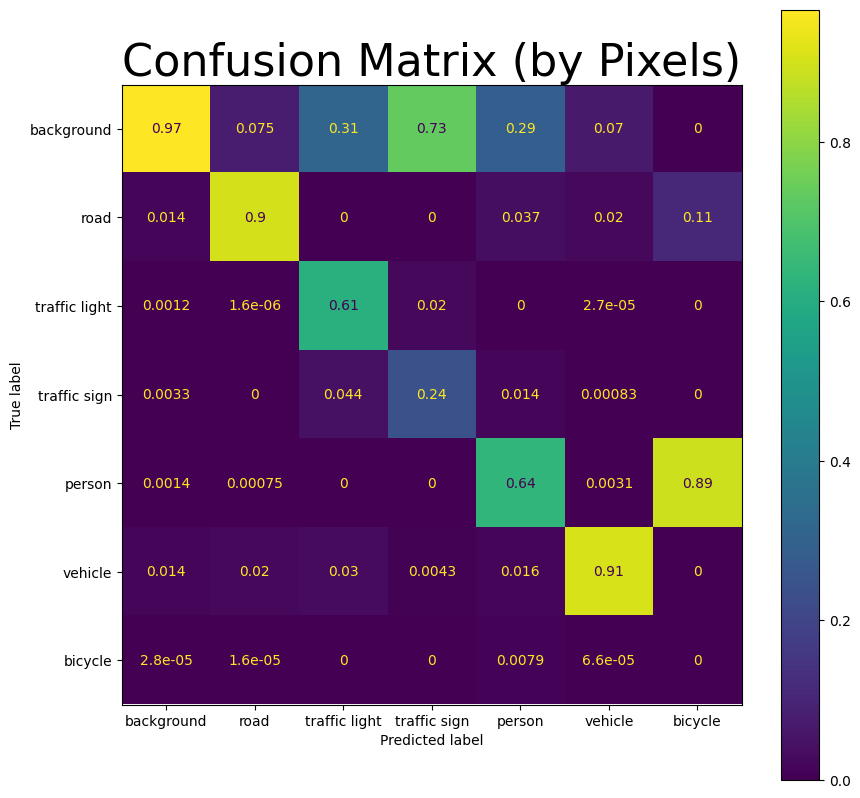

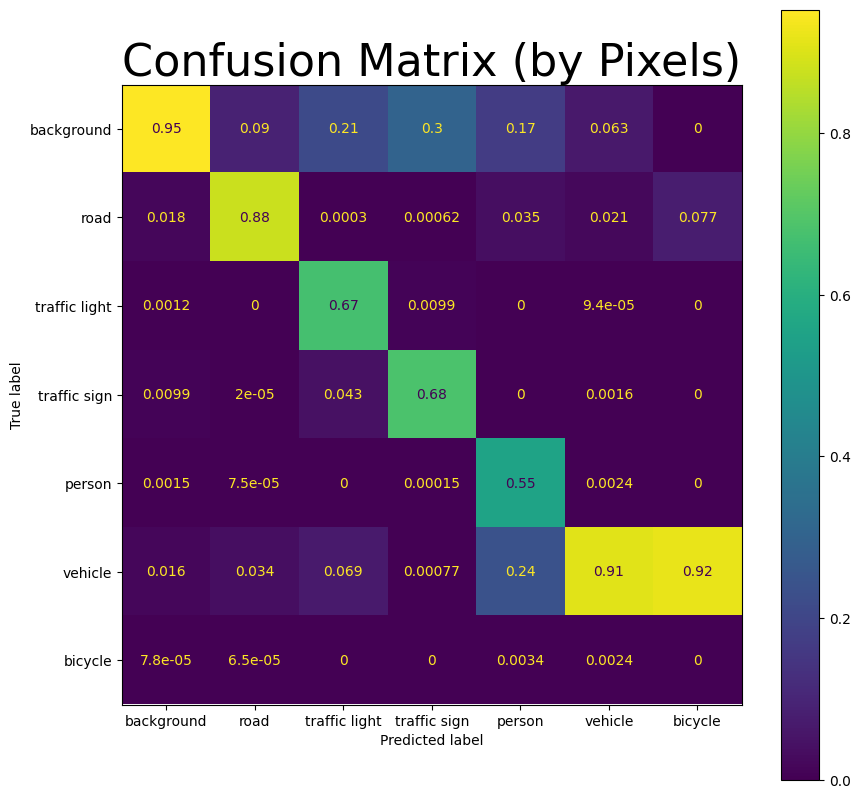

In [35]:
# Display diagnostics for the validation set and log confusion matrix and pixel count table to W&B
# Get pixel predictions and confusion matrix for validation set
val_count_df, val_disp = display_diagnostics(learner=learn, dls=learn.dls.valid, return_vals=True)

# Log the validation confusion matrix to W&B
wandb.log({'val_confusion_matrix': val_disp.figure_})
# Create a W&B Table for pixel counts in validation set
val_ct_table = wandb.Table(dataframe=val_count_df)
# Log the pixel count table to W&B
wandb.log({'val_count_table': val_ct_table})

# Display diagnostics for the test set and log confusion matrix and pixel count table to W&B
# Get pixel predictions and confusion matrix for test set
# use learn.dls[0] instead of learn.dls.test
test_count_df, test_disp = display_diagnostics(learner=learn, dls=learn.dls[0], return_vals=True)

# Log the test confusion matrix to W&B
wandb.log({'test_confusion_matrix': test_disp.figure_})
# Create a W&B Table for pixel counts in test set
test_ct_table = wandb.Table(dataframe=test_count_df)
# Log the pixel count table to W&B
wandb.log({'test_count_table': test_ct_table})


### 🔍 Final Visual Results

Here is the final model evaluation, showcasing the confusion matrix, histograms, logged losses, IoU metrics for each class, and prediction tables. You can explore more details on the W&B project dashboard for comprehensive insights.


<img src="https://drive.google.com/uc?id=17r7sJ6imX03o42xVwh1-VZ4b7bAqZmvH" alt="GIF" width="730" height="550">


Below is an example of the model prediction compared to the ground truth segmentation. First, we present a class-by-class mask comparison overlaid on the original image, followed by a comparison of all the ground truth and predicted classes together.

<img src="https://drive.google.com/uc?id=11UKUhXO8XSmjLn-JgnqjOr1iKvGDRE6u" alt="GIF" width="730" height="550">

In [36]:
run.finish()

test_background_iou,0.92451
test_bicycle_iou,0
test_loss,0.30258
test_miou,0.44921
test_person_iou,0.24174
test_road_iou,0.81097
test_traffic_light_iou,0.2705
test_traffic_sign_iou,0.09525
test_vehicle_iou,0.80152
val_background_iou,0.93128
val_bicycle_iou,0
